<a href="https://colab.research.google.com/github/uptrain-ai/uptrain/blob/main/examples/integrations/observation_tools/helicone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="UpTrain">
  </a>
</h1>

<div style="text-align: center;">

#  LLM Evaluations with Helicone and UpTrain

[Helicone](https://www.helicone.ai/) helps you understand how your application is performing with its monitoring tools. 

This notebook demonstrates how to use Helicone for monitoring and log your UpTrain evaluations in Helicone Dashboard

If you face any difficulties, need some help with using UpTrain or want to brainstorm custom evaluations for your use-case, you can speak to the maintainers of UpTrain [here](https://calendly.com/uptrain-sourabh/30min).

### Prerequisites: Install Required Libraries

In [1]:
%pip install openai uptrain -qU

Note: you may need to restart the kernel to use updated packages.


### Step 1: Define Your OpenAI and Helicone Key


You can get your Helicone API keys [here](https://www.helicone.ai/developer) and OpenAI API key [here](https://platform.openai.com/api-keys)

In [2]:
import os
HELICONE_API_KEY = os.environ["HELICONE_API_KEY"]
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

### Step 2: Define OpenAI client

In [3]:
import os
from openai import OpenAI
import uuid
import requests

update_headers = {
    'Authorization': f'Bearer {HELICONE_API_KEY}',
    'Content-Type': 'application/json',
}

client = OpenAI(
  api_key=OPENAI_API_KEY,  # Replace with your OpenAI API key
  base_url="http://oai.hconeai.com/v1",  # Set the API endpoint
  default_headers= {  # Optionally set default headers or set per request (see below)
    "Helicone-Auth": f"Bearer {HELICONE_API_KEY}",
  }
)

### Step 3: Let's create a dataset

In [4]:
data = [
    {
        "question": "What causes diabetes?",
        "context": "Diabetes is a metabolic disorder characterized by high blood sugar levels. It is primarily caused by a combination of genetic and environmental factors, including obesity and lack of physical activity.",
    },
    {
        "question": "What is the capital of France?",
        "context": "Paris is the capital of France. It is a place where people speak French and enjoy baguettes. I once heard that the Eiffel Tower was built by aliens, but don\'t quote me on that.",
    },
    {
        "question": "How is pneumonia treated?",
        "context": "Pneumonia is an infection that inflames the air sacs in one or both lungs. It is typically treated with antibiotics, rest, and supportive care. The choice of antibiotics depends on the type of pneumonia and its severity.",
    }
]

### Step 4: Define your prompt

In [5]:
def create_prompt(question, context):
    prompt = f"""
    Context information is below.
    ---------------------
    {context}
    ---------------------
    Given the context information and not prior knowledge, answer the query.
    Query: {question}
    Answer:
    """
    return prompt

### Step 5: Define a function to generate responses

In [6]:
def generate_responses(prompt):
  response = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role": "user", "content": prompt}
    ],
    extra_headers={ # Can also attach headers per request
        "Helicone-Auth": f"Bearer {HELICONE_API_KEY}",
        "Helicone-Request-Id": f"{my_helicone_request_id}"
    },
  ).choices[0].message.content
  return response

### Step 6: Define UpTrain Function to run Evaluations

In [7]:
from uptrain import EvalLLM, Evals, ResponseMatching

eval_llm = EvalLLM(openai_api_key = OPENAI_API_KEY)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lazy_loader/__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)


We have used the following 5 metrics from UpTrain's library:

1. [Response Conciseness](https://docs.uptrain.ai/predefined-evaluations/response-quality/response-conciseness): Evaluates how concise the generated response is or if it has any additional irrelevant information for the question asked.

2. [Factual Accuracy](https://docs.uptrain.ai/predefined-evaluations/context-awareness/factual-accuracy): Evaluates whether the response generated is factually correct and grounded by the provided context.

3. [Context Utilization](https://docs.uptrain.ai/predefined-evaluations/context-awareness/context-utilization): Evaluates how complete the generated response is for the question specified given the information provided in the context. Also known as Reponse Completeness wrt context

4. [Response Relevance](https://docs.uptrain.ai/predefined-evaluations/response-quality/response-relevance): Evaluates how relevant the generated response was to the question specified.

Each score has a value between 0 and 1. 

You can look at the complete list of UpTrain's supported metrics [here](https://docs.uptrain.ai/predefined-evaluations/overview)

In [8]:
def uptrain_evaluate(item):
    res = eval_llm.evaluate(
        project_name = "Helicone-Demo",
        data = item,
        checks = [
        Evals.RESPONSE_CONCISENESS,
        Evals.RESPONSE_RELEVANCE,
        Evals.RESPONSE_COMPLETENESS_WRT_CONTEXT,
        Evals.FACTUAL_ACCURACY,
        ]
    )
    return res

### Step 7: Run the evaluations and log the data to Helicone 

In [9]:
results = []
for index in range(len(data)):
    
    question = data[index]['question']
    context = data[index]['context']    
    
    prompt = create_prompt(question, context)
    
    my_helicone_request_id = str(uuid.uuid4())
    
    response = generate_responses(prompt)
    
    eval_data = [
        {
            'question': question,
            'context': context, 
            'response': response, 
        }
    ]
    
    
    result = uptrain_evaluate(eval_data)
    results.append(result)
    
    for i in result[0].keys():
        if i.startswith('score') or i.startswith('explanation'):
            json_data = {
                            'key': i,
                            'value': str(result[0][i]),
                        }
            status = requests.put(f'https://api.hconeai.com/v1/request/{my_helicone_request_id}/property', headers=update_headers, json=json_data)

100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


Let's look at an evaluation generated by UpTrain

In [10]:
from pprint import pprint
pprint(results[0], indent = 2)

[ { 'context': 'Diabetes is a metabolic disorder characterized by high blood '
               'sugar levels. It is primarily caused by a combination of '
               'genetic and environmental factors, including obesity and lack '
               'of physical activity.',
    'explanation_factual_accuracy': '[\n'
                                    '    {\n'
                                    '        "Fact": "1. Diabetes is primarily '
                                    'caused by a combination of genetic and '
                                    'environmental factors.",\n'
                                    '        "Reasoning": "The context '
                                    'explicitly states that diabetes is '
                                    'primarily caused by a combination of '
                                    'genetic and environmental factors, '
                                    'including obesity and lack of physical '
                                    'ac

### Visualize Results in Helicone Dashboards

You can log into [Helicone Dashoards](https://www.helicone.ai/dashboard) to observe your LLM applications over cost, tokens, latency

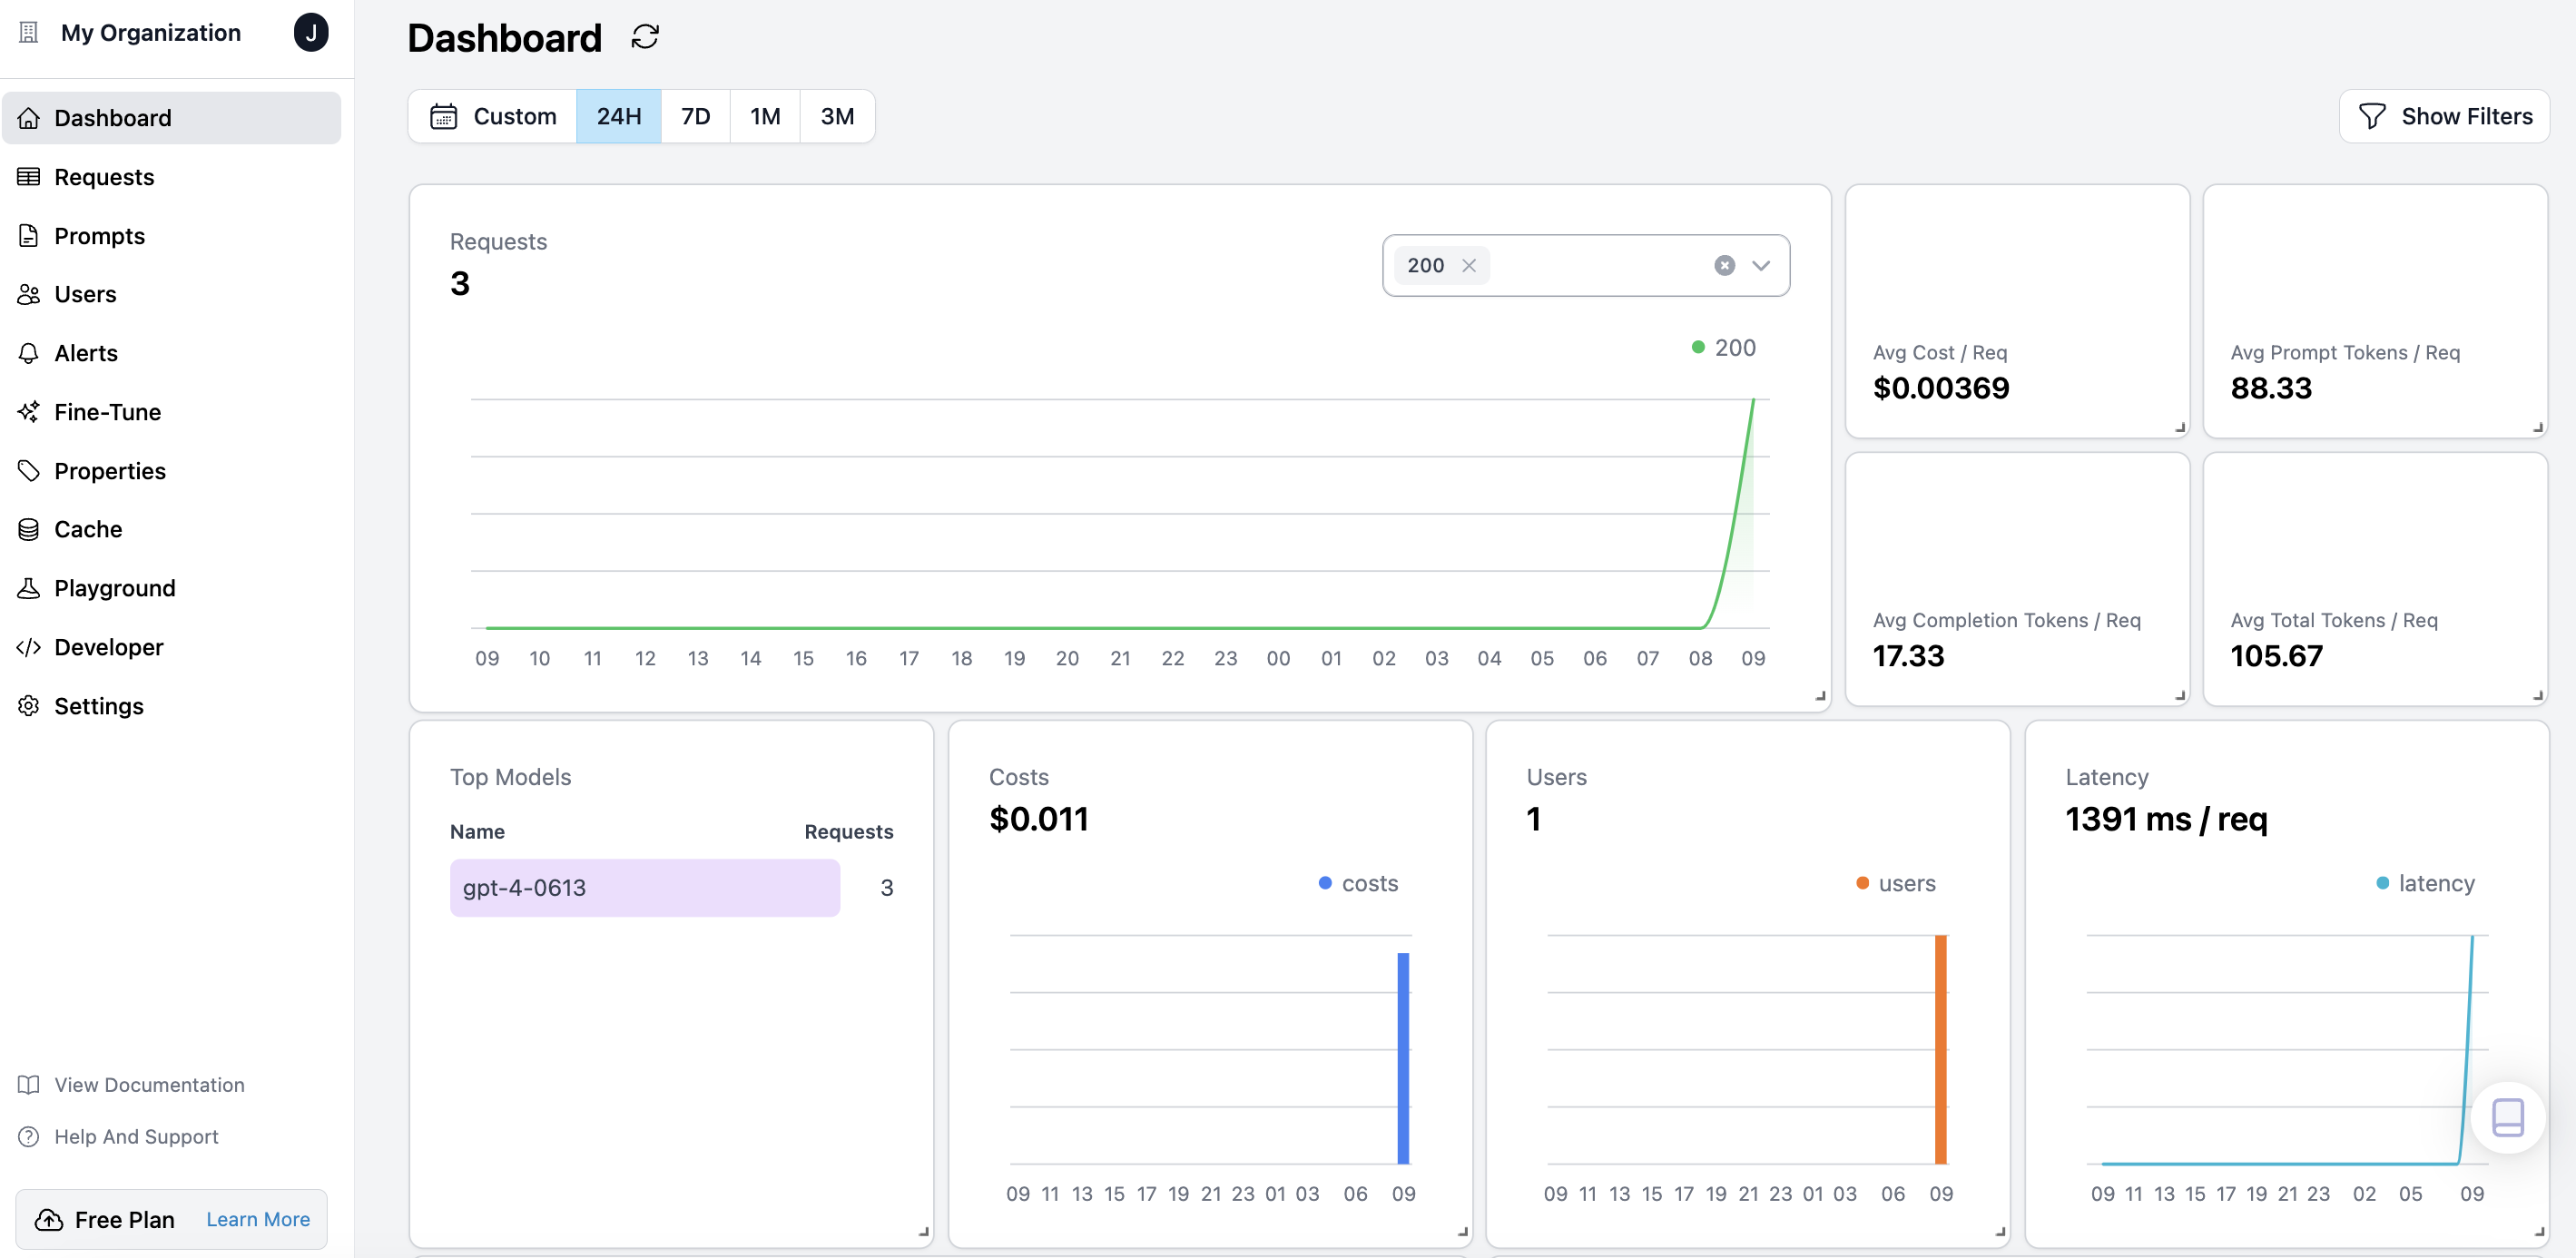

You can also look at individual records

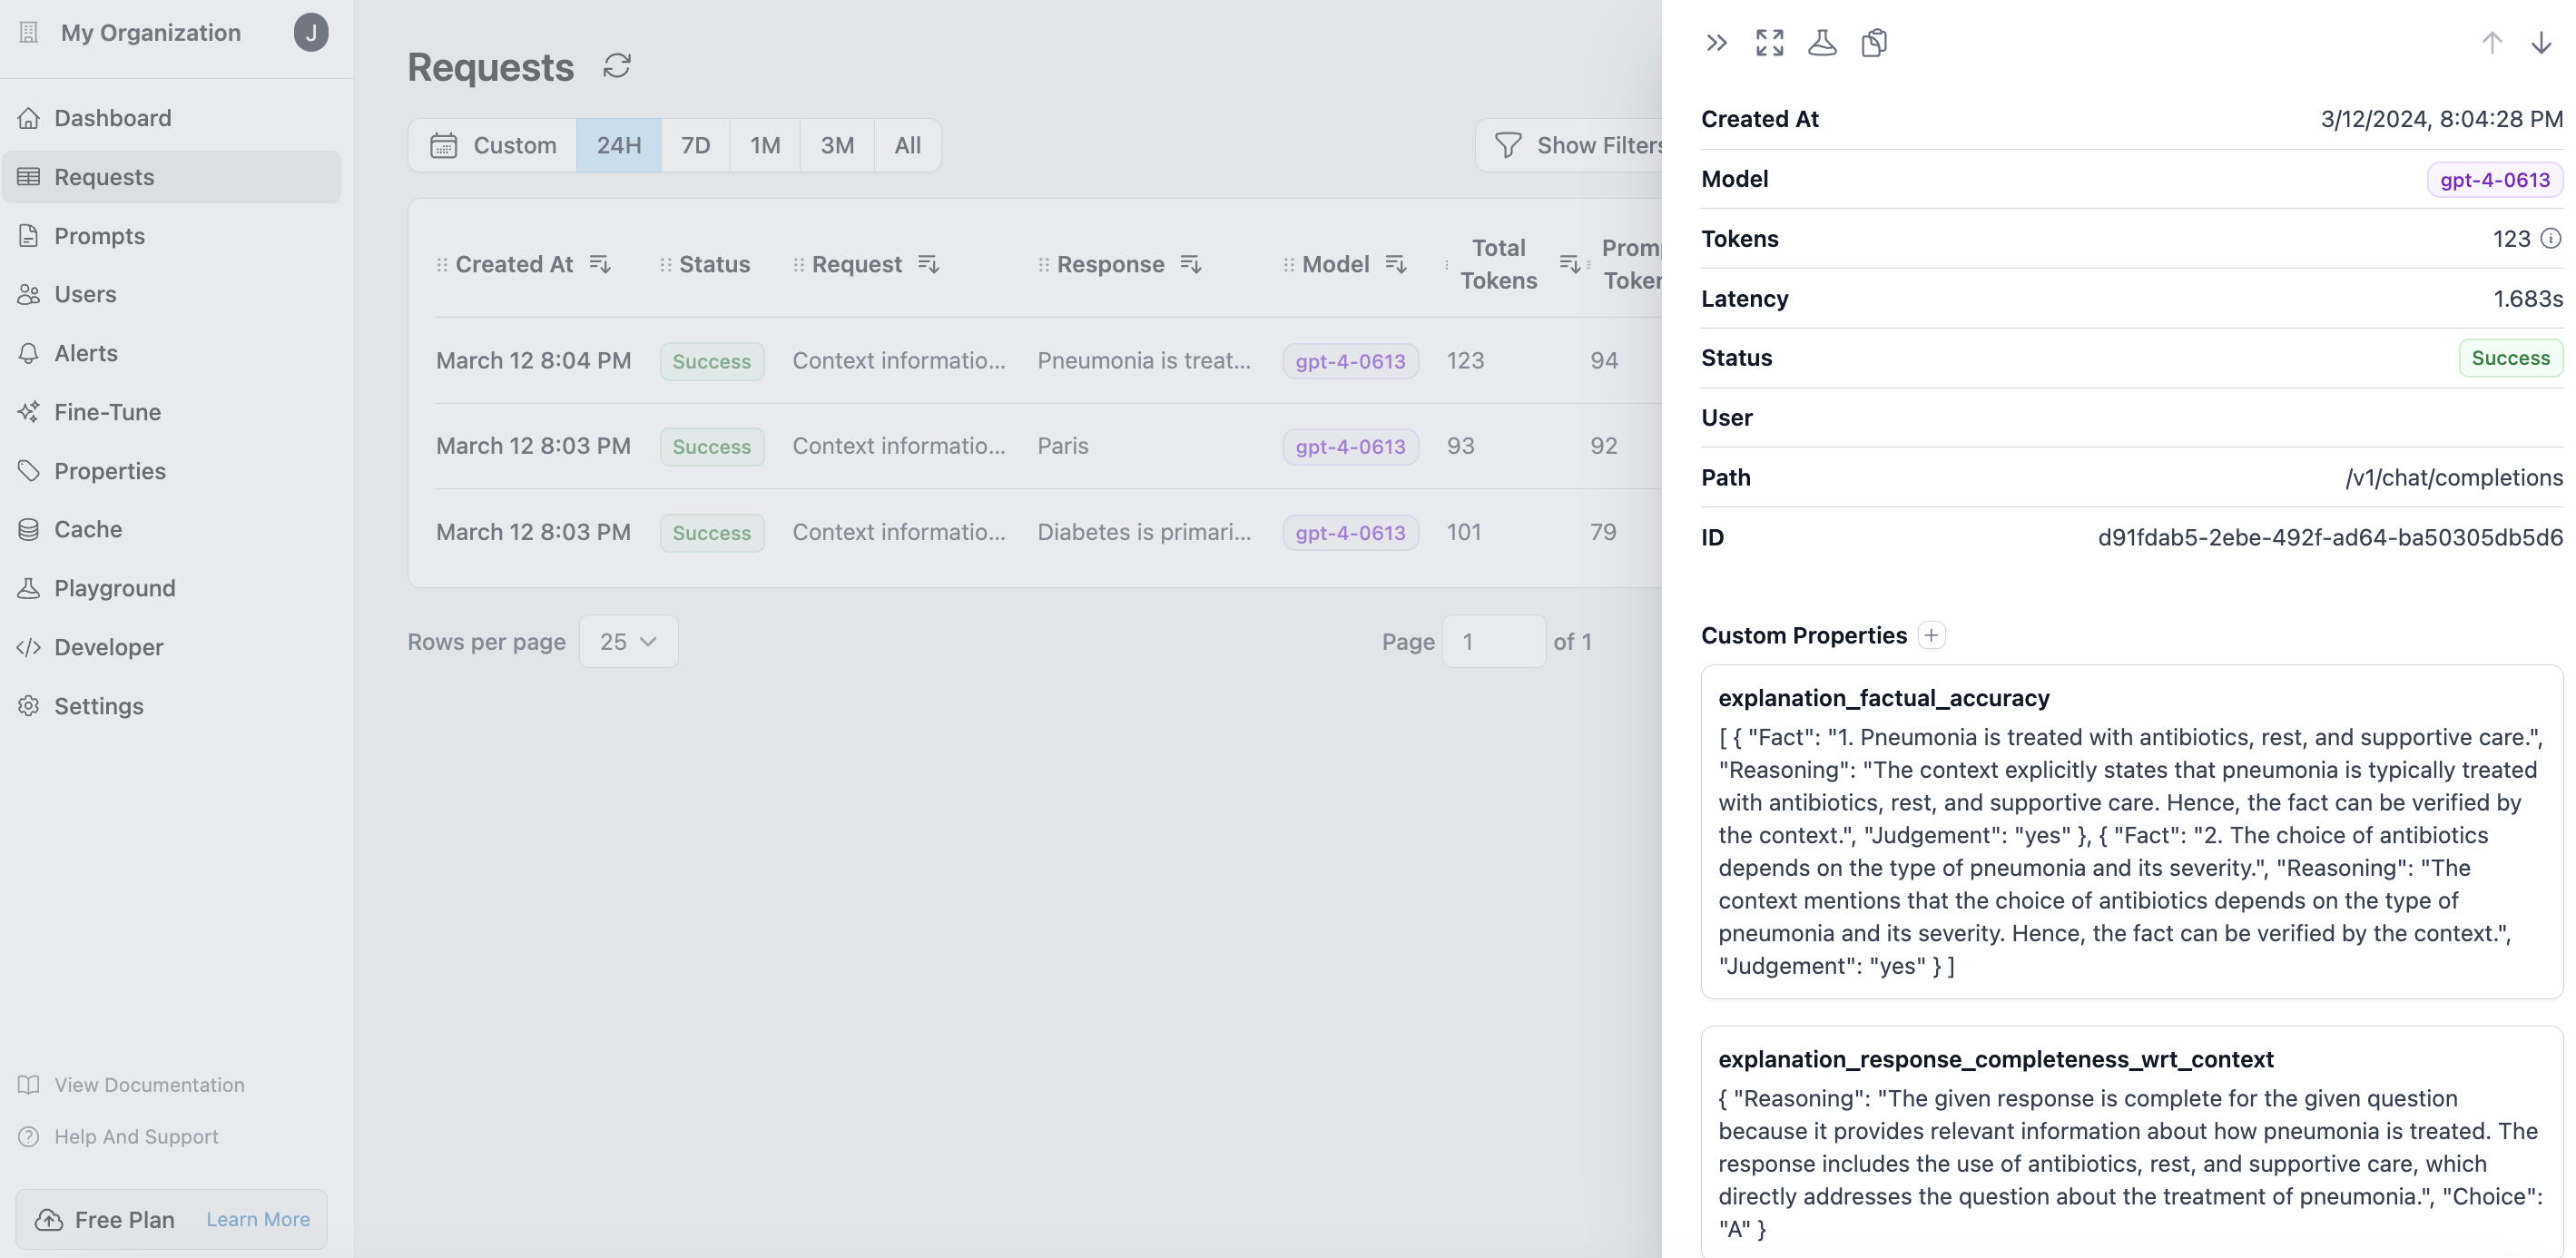